In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import traceback
import numpy as np
import matplotlib
import shapefile
import pygeoif
import snappy
import pandas as pd
import os

from snappy import Product
from snappy import ProductIO
from snappy import ProductUtils
from snappy import WKTReader
from snappy import HashMap
from snappy import GPF
from snappy import jpy
from snappy import GeoPos
from snappy import PixelPos

In [3]:
import skimage.exposure as exposure # Correr dos veces si llega a fallar

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.display.max_columns = 999

%matplotlib inline

In [3]:
def plot_band(band_data, gray=True):
    val1, val2 = np.percentile(band_data, (2.5,97.5))
    band_data_new = exposure.rescale_intensity(band_data, in_range=(val1,val2))

    plt.figure(figsize=(8, 8))                     
    fig = (
        plt.imshow(band_data_new, cmap = cm.gray)
        if gray else plt.imshow(band_data_new)
    )
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()


def get_band_array(product, band):
    band_data = product.getBand(band)
    width, height = band_data.getRasterWidth(), band_data.getRasterHeight()
    band_data_array = np.zeros(width*height, dtype = np.float32)
    band_data.readPixels(0, 0, width, height, band_data_array)
    band_data_array.shape = height, width

    print(width, height)
    return band_data_array


def categorize_bands(x):
    categories = [
        "NO_DATA", "SATURATED_DEFECTIVE", "DARK_FEATURE_SHADOW",
        "CLOUD_SHADOW", "VEGETATION", "NOT_VEGETATION",
        "WATER", "UNCLASSIFIED", "CLOUD_MEDIUM_PROBA",
        "CLOUD_HIGH_PROBA", "THIN_CIRRUS", "SNOW_ICE"
    ]
    
    for i in range(len(categories)):
        if x == i:
            return categories[i]

        
def get_pixel_into_df(df, product):
    
    gc = product.getSceneGeoCoding()
    bands_names = list(product.getBandNames())
    
    cols = ['X', 'Y']
    cols.extend(df.columns)
    cols.extend(bands_names)
    
    df_bands = pd.DataFrame(columns=cols)
    rows = df.shape[0]
    
    for j in range(rows):
        
        lat, lon = df.loc[j][['lat', 'lon']]
        pixel_pos = gc.getPixelPos(GeoPos(lat, lon), None)

    #     print("(lat, lon) -→ (X, Y) : (%s, %s) -→ (%s, %s)" % (lat, lon, int(pixel_pos.x), int(pixel_pos.y)))

        data = [int(pixel_pos.x), int(pixel_pos.y)]
        
        for col in df.columns:
            data.append(df.loc[j, col])

        for i, band_name in enumerate(bands_names):

            temp_band = product.getBand(band_name)
            width, height = temp_band.getRasterWidth(), temp_band.getRasterHeight()
            try:
                tmp = np.zeros(1)
                temp_band.readPixels(int(pixel_pos.x), int(pixel_pos.y), 1, 1, tmp)
                data.append(tmp[0])
            except Exception as e:
                print(band_name)
                print(width, height)
                print(int(pixel_pos.x), int(pixel_pos.y))
                data.append(-9999999)
                print(e)
                traceback.print_exc()
#         print(len(data))
        df_bands.loc[df_bands.shape[0]] = data
    return df_bands


def get_operator_info(name):

    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(name)

    print('Operator name: %s' % op_spi.getOperatorDescriptor().getName())
    print('Operator alias: %s\n' % op_spi.getOperatorDescriptor().getAlias())

    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
        info = (
            "Name \"%s\": {\n\tAlias: %s,\n\tdtype: %s,\n\tdefault value: %s,\n\tdescription: %s\n}\n" %
            (
                param.getName(), param.getAlias(), param.getDataType().getName(),
                param.getDefaultValue(), param.getDescription()
            )
        )
        print(info)
    #     print(help(param.getDataType())) 

In [4]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

---

In [7]:
ls "../../data/raw/sentinel_satellite_images/"

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: CAD2-CEC1

 Directorio de C:\Users\camil\codes\tesis\data\raw\sentinel_satellite_images

29/04/2021  02:29 a.ÿm.    <DIR>          .
29/04/2021  02:29 a.ÿm.    <DIR>          ..
29/04/2021  02:20 a.ÿm.       795.770.806 S2A_MSIL1C_20151221T153112_N0201_R025_T18NXM_20151221T153112.zip
29/04/2021  02:21 a.ÿm.       198.364.011 S2A_MSIL1C_20151228T151652_N0201_R125_T18NXM_20151228T151649.zip
24/04/2021  12:34 a.ÿm.    <DIR>          S2A_MSIL1C_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE
25/04/2021  06:40 a.ÿm.    <DIR>          S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.SAFE
               2 archivos    994.134.817 bytes
               4 dirs  591.600.844.800 bytes libres


In [8]:
ls "../../data/processed_raw/sentinel_satellite_images/"

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: CAD2-CEC1

 Directorio de C:\Users\camil\codes\tesis\data\processed_raw\sentinel_satellite_images

29/04/2021  01:45 a.ÿm.    <DIR>          .
29/04/2021  01:45 a.ÿm.    <DIR>          ..
29/04/2021  01:45 a.ÿm.    <DIR>          RGB images
26/04/2021  08:37 p.ÿm.    <DIR>          S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED.data
26/04/2021  08:34 p.ÿm.        27.608.000 S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED.dim
               1 archivos     27.608.000 bytes
               4 dirs  591.600.828.416 bytes libres


---

### Read product

In [9]:
path_to_sentinel_data = "../S2A_MSIL1C_20151228T151652_N0201_R125_T18NXM_20151228T151649.zip"
product = ProductIO.readProduct(path_to_sentinel_data)

In [10]:
print(list(product.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12']


---
### Atmospheric correction

In [13]:
get_operator_info('Sen2Cor255')

Operator name: Sen2Cor255
Operator alias: Sen2Cor255

Name "targetProductFile": {
	Alias: None,
	dtype: java.io.File,
	default value: None,
	description: Output file
}

Name "postExecuteTemplate": {
	Alias: None,
	dtype: java.io.File,
	default value: Sen2Cor-post-template.vm,
	description: 
}

Name "sceneOnly": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: None,
	description: Scene Only
}

Name "resolution": {
	Alias: None,
	dtype: java.lang.String,
	default value: 60,
	description: None
}

Name "crOnly": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: false,
	description: None
}

Name "useL2AGIPP": {
	Alias: <html><body>L2A_GIPP file<br>(If a file is selected,<br>the parameters below<br>will not be used)</body></html>,
	dtype: java.io.File,
	default value: ,
	description: Use configuration from GIPP file
}

Name "gip25L2A": {
	Alias: None,
	dtype: java.io.File,
	default value: Sen2Cor-gipp-template.xsl,
	description: GIPP parameter file
}

Name "gipL2A": {
	Ali

In [3]:
# cmd = ‘Sen2Cor-02.05.05-win64\L2A_Process ‘+path+’ --resolution=60’
# subprocess.call(cmd, shell=True)

In [14]:
parameters = HashMap()

parameters.put("resolution", "ALL") # 10, 20, 60
# parameters.put("targetProductFile", "../../data/processed_raw/")
product_atm_corr = GPF.createProduct("Sen2Cor255", parameters, product) # Sen2Cor255

In [15]:
print(list(product_atm_corr.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12']


In [13]:
# filename_out = 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105.dim'
# ProductIO.writeProduct(product_ac2, filename_out, 'BEAM-DIMAP')

In [17]:
b4_array = get_band_array(product_atm_corr, 'B4')

(10980L, 10980L)


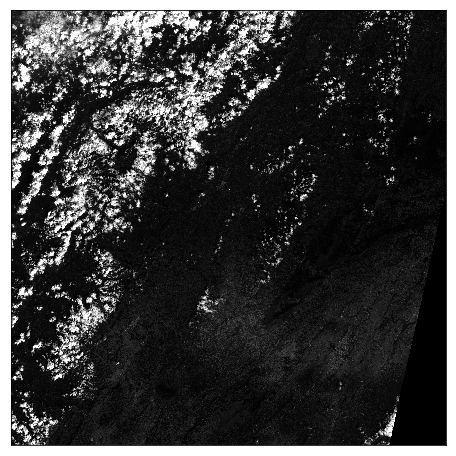

In [18]:
plot_band(b4_array)

---
### Resampling

In [18]:
get_operator_info('Resample')

Operator name: org.esa.snap.core.gpf.common.resample.ResamplingOp
Operator alias: Resample

Name "referenceBandName": {
	Alias: referenceBand,
	dtype: java.lang.String,
	default value: None,
	description: The name of the reference band. All other bands will be re-sampled to match its size and resolution. Either this or targetResolutionor targetWidth and targetHeight must be set.
}

Name "targetWidth": {
	Alias: targetWidth,
	dtype: java.lang.Integer,
	default value: None,
	description: The width that all bands of the target product shall have. If this is set, targetHeight must be set, too. Either this and targetHeight or referenceBand or targetResolution must be set.
}

Name "targetHeight": {
	Alias: targetHeight,
	dtype: java.lang.Integer,
	default value: None,
	description: The height that all bands of the target product shall have. If this is set, targetWidth must be set, too. Either this and targetWidth or referenceBand or targetResolution must be set.
}

Name "targetResolution": {

In [16]:
parameters_resample = HashMap()
target_resolution = 10 # 20, 60
upsampling_method = 'Nearest'
downsampling_method = 'Mean'
parameters_resample.put('downsamplingMethod', downsampling_method)
parameters_resample.put('upsamplingMethod', upsampling_method)
parameters_resample.put('targetResolution', target_resolution)

product_resample = snappy.GPF.createProduct('Resample', parameters_resample, product_atm_corr)

In [17]:
B4 = product_resample.getBand('B4')
B5 = product_resample.getBand('B5')

width_B4, height_B4 = B4.getRasterWidth(), B4.getRasterHeight()
width_B5, height_B5 = B5.getRasterWidth(), B5.getRasterHeight()

print("Band 4 Size: %s, %s" % (width_B4, height_B4))
print("Band 5 Size: %s, %s" % (width_B5, height_B5))

Band 4 Size: 10980, 10980
Band 5 Size: 10980, 10980


In [23]:
b8_array = get_band_array(product_resample, 'B8')

(10980L, 10980L)


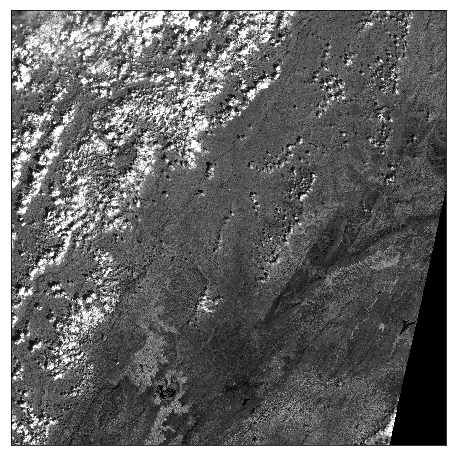

In [24]:
plot_band(b8_array)

---
### Subsetting

In [25]:
get_operator_info('Subset')

Operator name: org.esa.snap.core.gpf.common.SubsetOp
Operator alias: Subset

Name "bandNames": {
	Alias: sourceBands,
	dtype: [Ljava.lang.String;,
	default value: None,
	description: The list of source bands.
}

Name "region": {
	Alias: None,
	dtype: java.awt.Rectangle,
	default value: None,
	description: The subset region in pixel coordinates.
Use the following format: <x>,<y>,<width>,<height>
If not given, the entire scene is used. The 'geoRegion' parameter has precedence over this parameter.
}

Name "referenceBand": {
	Alias: referenceBand,
	dtype: java.lang.String,
	default value: None,
	description: The band used to indicate the pixel coordinates.
}

Name "geoRegion": {
	Alias: None,
	dtype: org.locationtech.jts.geom.Geometry,
	default value: None,
	description: The subset region in geographical coordinates using WKT-format,
e.g. POLYGON((<lon1> <lat1>, <lon2> <lat2>, ..., <lon1> <lat1>))
(make sure to quote the option due to spaces in <geometry>).
If not given, the entire scene i

In [18]:
geometry = WKTReader().read("POLYGON ((-73.7 5.85, -73.3 5.85, -73.3 6.2, -73.7 6.2, -73.7 5.85))")

In [19]:
parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geometry)
product_subset = snappy.GPF.createProduct('Subset', parameters, product_resample)

In [15]:
b6_array = get_band_array(product_subset, 'B6')

(4440L, 3884L)


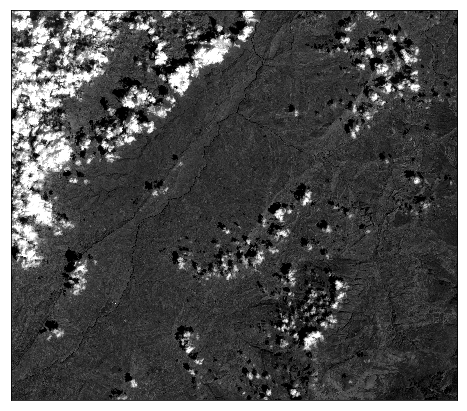

In [29]:
plot_band(b6_array)

---
### Cloud masking, Indices and ratios

In [30]:
get_operator_info('BandMaths')

Operator name: org.esa.snap.core.gpf.common.BandMathsOp
Operator alias: BandMaths

Name "targetBandDescriptors": {
	Alias: targetBands,
	dtype: [Lorg.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor;,
	default value: None,
	description: List of descriptors defining the target bands.
}

Name "variables": {
	Alias: variables,
	dtype: [Lorg.esa.snap.core.gpf.common.BandMathsOp$Variable;,
	default value: None,
	description: List of variables which can be used within the expressions.
}



In [20]:
names = [
    'CloudMask',
    'NDVI',
    'GNDVI',
    'EVI',
    'AVI',
    'SAVI',
    'NDMI',
    'MSI',
    'GCI',
    'NBR',
    'BSI',
    'NDWI',
    'NDSI',
    'NDGI',
    'ARVI',
    'SIPI'
]
expresions = [
    'if (scl_cloud_medium_proba || scl_cloud_high_proba || scl_thin_cirrus) then 1 else 0',
    '(B8-B4) / (B8+B4)',
    '(B8-B3) / (B8+B3)',
    '2.5*( (B8-B4) / ( (B8 + (6*B4) - (7.5*B2) + 1) ) )',
    'pow( B8 * (1-B4) * (B8-B4), 1/3)',
    '1.428 * ( (B8-B4) / (B8+B4+0.428) )',
    '(B8-B11) / (B8+B11)',
    'B11 / B8',
    '(B9 / B3) - 1',
    '(B8-B12) / (B8+B12)',
    '((B11+B4) - (B8+B2)) / ((B11+B4) + (B8+B2))',
    '(B3-B8) / (B3+B8)',
    '(B3-B11) / (B3+B11)',
    '(B8-B3) / (B8+B3)',
    '(B8 - (2*B4) + B2) / (B8 + (2*B4) + B2)',
    '(B8-B2) / (B8+B2)',
]

inds_ = [i for i in range(len(names))]

print(len(names) == len(expresions))

True


In [21]:
paramsCloud = HashMap()

targetBands = jpy.array(
    'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor',
    len(names)
)
BandDescriptor = jpy.get_type(
    'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor'
)

for i, name, expresion in zip(inds_, names, expresions):
    targetBand = BandDescriptor()
    targetBand.name = name
    targetBand.type = 'float32'
    targetBand.expression = expresion
    targetBands[i] = targetBand

paramsCloud.put('targetBands', targetBands)
productCloud = GPF.createProduct('BandMaths', paramsCloud, product_subset)

In [22]:
print(list(productCloud.getBandNames()))

['CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'NDGI', 'ARVI', 'SIPI']


(4440L, 3884L)


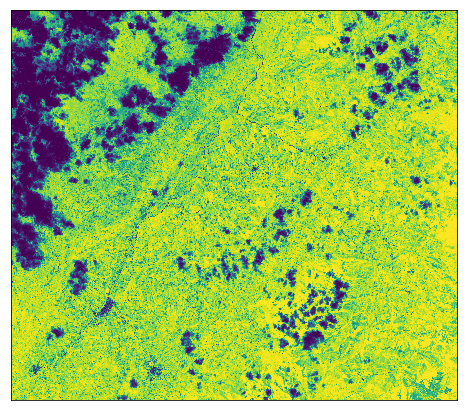

In [78]:
NDVI_array = get_band_array(productCloud, 'NDVI')
plot_band(NDVI_array, False)

(4440L, 3884L)


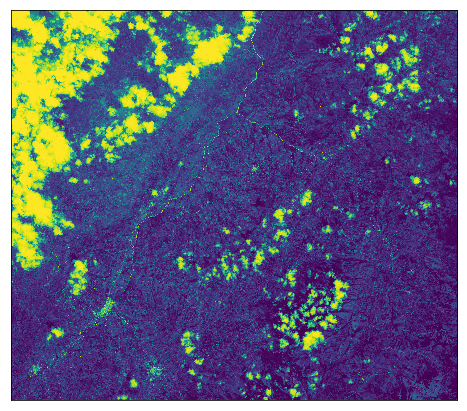

In [79]:
NDWI_array = get_band_array(productCloud, 'NDWI')
plot_band(NDWI_array, False)

(4440L, 3884L)


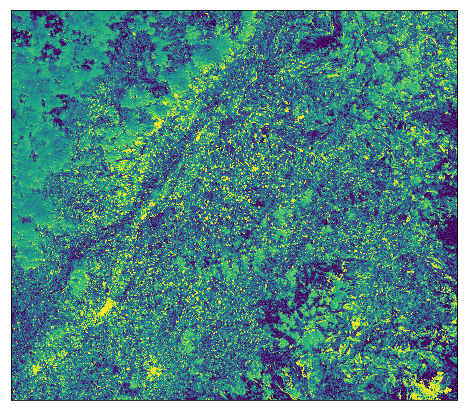

In [80]:
BSI_array = get_band_array(productCloud, 'BSI')
plot_band(BSI_array, False)

---
### Merge products

In [81]:
get_operator_info('Merge')

Operator name: org.esa.snap.core.gpf.common.MergeOp
Operator alias: Merge

Name "includes": {
	Alias: None,
	dtype: [Lorg.esa.snap.core.gpf.common.MergeOp$NodeDescriptor;,
	default value: None,
	description: Defines nodes to be included in the master product. If no includes are provided, all nodes are copied.
}

Name "excludes": {
	Alias: None,
	dtype: [Lorg.esa.snap.core.gpf.common.MergeOp$NodeDescriptor;,
	default value: None,
	description: Defines nodes to be excluded from the target product. Excludes have precedence above includes.
}

Name "geographicError": {
	Alias: None,
	dtype: float,
	default value: 1.0E-5f,
	description: Defines the maximum lat/lon error in degree between the products. If set to NaN no check for compatible geographic boundary is performed
}



In [23]:
sourceProducts= HashMap()
sourceProducts.put('masterProduct', product_subset)
sourceProducts.put('slaveProduct', productCloud)
parametersMerge = HashMap()
productMerged = GPF.createProduct('Merge', parametersMerge, sourceProducts)

In [24]:
# parameters = HashMap()
# target = GPF.createProduct("BandMerge", parameters, (product_subset, product_subset_ndvi))

In [25]:
print(list(productMerged.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'NDGI', 'ARVI', 'SIPI']


---
### Save product

In [4]:
filename_out = '../../data/processed_raw/sentinel_satellite_images/S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED.dim'
ProductIO.writeProduct(productMerged, filename_out, 'BEAM-DIMAP')

In [ ]:

# def createProgressMonitor():
#     PWPM = jpy.get_type('com.bc.ceres.core.PrintWriterProgressMonitor')
#     JavaSystem = jpy.get_type('java.lang.System')
#     monitor = PWPM(JavaSystem.out)
#     return monitor

# incremental = False
# pm = createProgressMonitor()
# filename_out = 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput3.dim'
# GPF.writeProduct(product_subset , 'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_subsetoutput2.dim', 'BEAM-DIMAP', incremental, pm)

---
## End of processing
---

### Extract pixel values

In [5]:
path_to_sentinel_data = (
    "../../data/processed_raw/sentinel_satellite_images/" +
    "S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED.dim"
)
product_pixel_extraction = ProductIO.readProduct(path_to_sentinel_data)

In [6]:
print(list(product_pixel_extraction.getBandNames()))

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'quality_aot', 'quality_wvp', 'quality_cloud_confidence', 'quality_snow_confidence', 'quality_scene_classification', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12', 'CloudMask', 'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI', 'NDMI', 'MSI', 'GCI', 'NBR', 'BSI', 'NDWI', 'NDSI', 'NDGI', 'ARVI', 'SIPI']


---
#### Soil_data

In [7]:
path_nirs = os.path.abspath(
    "../../data/processed_raw/soil_cane_vis_NIRS/soil_cane_vis_NIR_georeferenced.csv"
)
soil_nir_data = pd.read_csv(path_nirs, sep=';')
print(soil_nir_data.shape)
soil_nir_data.head()

(653, 259)


,lon,lat,departamento,municipio,cultivo,topografia,pH,OM,Ca,Mg,K,Na,400,408.5,417,425.5,434,442.5,451,459.5,468,476.5,485,493.5,502,510.5,519,527.5,536,544.5,553,561.5,570,578.5,587,595.5,604,612.5,621,629.5,638,646.5,655,663.5,672,680.5,689,697.5,706,714.5,723,731.5,740,748.5,757,765.5,774,782.5,791,799.5,808,816.5,825,833.5,842,850.5,859,867.5,876,884.5,893,901.5,910,918.5,927,935.5,944,952.5,961,969.5,978,986.5,995,1003.5,1012,1020.5,1029,1037.5,1046,1054.5,1063,1071.5,1080,1088.5,1097,1105.5,1114,1122.5,1131,1139.5,1148,1156.5,1165,1173.5,1182,1190.5,1199,1207.5,1216,1224.5,1233,1241.5,1250,1258.5,1267,1275.5,1284,1292.5,1301,1309.5,1318,1326.5,1335,1343.5,1352,1360.5,1369,1377.5,1386,1394.5,1403,1411.5,1420,1428.5,1437,1445.5,1454,1462.5,1471,1479.5,1488,1496.5,1505,1513.5,1522,1530.5,1539,1547.5,1556,1564.5,1573,1581.5,1590,1598.5,1607,1615.5,1624,1632.5,1641,1649.5,1658,1666.5,1675,1683.5,1692,1700.5,1709,1717.5,1726,1734.5,1743,1751.5,1760,1768.5,1777,1785.5,1794,1802.5,1811,1819.5,1828,1836.5,1845,1853.5,1862,1870.5,1879,1887.5,1896,1904.5,1913,1921.5,1930,1938.5,1947,1955.5,1964,1972.5,1981,1989.5,1998,2006.5,2015,2023.5,2032,2040.5,2049,2057.5,2066,2074.5,2083,2091.5,2100,2108.5,2117,2125.5,2134,2142.5,2151,2159.5,2168,2176.5,2185,2193.5,2202,2210.5,2219,2227.5,2236,2244.5,2253,2261.5,2270,2278.5,2287,2295.5,2304,2312.5,2321,2329.5,2338,2346.5,2355,2363.5,2372,2380.5,2389,2397.5,2406,2414.5,2423,2431.5,2440,2448.5,2457,2465.5,2474,2482.5,2491
0,-73.513627,5.914703,BOYACA,TOGUI,PRADERAS,PENDIENTE,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.864947,0.875096,0.874840,0.865835,0.851385,0.838967,0.833089,0.831834,0.829409,0.821083,0.804732,0.781411,0.754565,0.726855,0.699120,0.671711,0.645430,0.620700,0.597969,0.578164,0.561325,0.547276,0.535821,0.526254,0.517484,0.508804,0.500029,0.490974,0.481710,0.472552,0.463779,0.455267,0.446919,0.438797,0.430990,0.423477,0.416262,0.409397,0.402926,0.396868,0.391249,0.386078,0.381368,0.377009,0.372938,0.369263,0.365900,0.362648,0.359597,0.357002,0.354811,0.352839,0.351035,0.349361,0.347768,0.346174,0.344563,0.342891,0.341143,0.339336,0.337482,0.335549,0.333536,0.331486,0.329428,0.327349,0.325065,0.322451,0.319854,0.317311,0.314750,0.312152,0.309510,0.306817,0.304093,0.301341,0.298579,0.295792,0.292908,0.289999,0.287228,0.284353,0.283089,0.281201,0.278312,0.275537,0.272863,0.270239,0.267772,0.265380,0.262955,0.260540,0.258260,0.256150,0.254174,0.252268,0.250496,0.248873,0.247394,0.245920,0.244449,0.243111,0.241952,0.240966,0.240199,0.239586,0.239062,0.238526,0.238026,0.237610,0.237241,0.237179,0.237467,0.238237,0.241019,0.247080,0.254199,0.262838,0.273027,0.271430,0.258304,0.252329,0.250347,0.249300,0.248436,0.247419,0.246041,0.244631,0.243330,0.242029,0.240771,0.239711,0.238736,0.237905,0.237270,0.236672,0.236050,0.235446,0.234947,0.234472,0.234067,0.233801,0.233743,0.233541,0.233192,0.233031,0.233040,0.233175,0.233203,0.233368,0.233545,0.233639,0.233758,0.234119,0.234678,0.235347,0.235903,0.236424,0.237248,0.237944,0.238584,0.239172,0.239647,0.240043,0.240303,0.240356,0.240381,0.240431,0.240561,0.240843,0.241173,0.242149,0.244453,0.249967,0.259104,0.273321,0.293150,0.311237,0.319497,0.320590,0.318971,0.316020,0.312332,0.308365,0.304471,0.300706,0.296996,0.293401,0.290109,0.287352,0.285200,0.283619,0.282698,0.282281,0.282181,0.282083,0.281997,0.282220,0.282852,0.283709,0.284802,0.285686,0.285798,0.286366,0.288598,0.293382,0.300520,0.308918,0.318419,0.329288,0.340154,0.348658,0.352795,0.334400,0.314162,0.306352,0.304565,0.305447,0.306978,0.308682,0.310445,0.312503,0.315896,0.320470,0.325842,0.330688,0.334873,0.339626,0.344934,0.349835,0.351331,0.351759,0.355015,0.359075,0.360628,0.361674,0.365246,0.371383,0.378890,0.386586,0.392239,0.395681,0.398774,0.402525,0.406814,0.411534,0.414343
1,-73.507327,5.914703,BOYACA,TOGUI,PRADERA,ONDULADO,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,1.069311,1.083294,1.088555,1.088504,1.085334,1.083149,1.082783,1.083112,1.081964,1.076658,1.

In [8]:
df_soil_nir_data_pixels = get_pixel_into_df(soil_nir_data, product_pixel_extraction)
print(df_soil_nir_data_pixels.shape)
df_soil_nir_data_pixels.head()

(653, 324)


,X,Y,lon,lat,departamento,municipio,cultivo,topografia,pH,OM,Ca,Mg,K,Na,400,408.5,417,425.5,434,442.5,451,459.5,468,476.5,485,493.5,502,510.5,519,527.5,536,544.5,553,561.5,570,578.5,587,595.5,604,612.5,621,629.5,638,646.5,655,663.5,672,680.5,689,697.5,706,714.5,723,731.5,740,748.5,757,765.5,774,782.5,791,799.5,808,816.5,825,833.5,842,850.5,859,867.5,876,884.5,893,901.5,910,918.5,927,935.5,944,952.5,961,969.5,978,986.5,995,1003.5,1012,1020.5,1029,1037.5,1046,1054.5,1063,1071.5,1080,1088.5,1097,1105.5,1114,1122.5,1131,1139.5,1148,1156.5,1165,1173.5,1182,1190.5,1199,1207.5,1216,1224.5,1233,1241.5,1250,1258.5,1267,1275.5,1284,1292.5,1301,1309.5,1318,1326.5,1335,1343.5,1352,1360.5,1369,1377.5,1386,1394.5,1403,1411.5,1420,1428.5,1437,1445.5,1454,1462.5,1471,1479.5,1488,1496.5,1505,1513.5,1522,1530.5,1539,1547.5,1556,1564.5,1573,1581.5,1590,1598.5,1607,1615.5,1624,1632.5,1641,1649.5,1658,1666.5,1675,1683.5,1692,1700.5,1709,1717.5,1726,1734.5,1743,1751.5,1760,1768.5,1777,1785.5,1794,1802.5,1811,1819.5,1828,1836.5,1845,1853.5,1862,1870.5,1879,1887.5,1896,1904.5,1913,1921.5,1930,1938.5,1947,1955.5,1964,1972.5,1981,1989.5,1998,2006.5,2015,2023.5,2032,2040.5,2049,2057.5,2066,2074.5,2083,2091.5,2100,2108.5,2117,2125.5,2134,2142.5,2151,2159.5,2168,2176.5,2185,2193.5,2202,2210.5,2219,2227.5,2236,2244.5,2253,2261.5,2270,2278.5,2287,2295.5,2304,2312.5,2321,2329.5,2338,2346.5,2355,2363.5,2372,2380.5,2389,2397.5,2406,2414.5,2423,2431.5,2440,2448.5,2457,2465.5,2474,2482.5,2491,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,quality_aot,quality_wvp,quality_cloud_confidence,quality_snow_confidence,quality_scene_classification,view_zenith_mean,view_azimuth_mean,sun_zenith,sun_azimuth,view_zenith_B1,view_azimuth_B1,view_zenith_B2,view_azimuth_B2,view_zenith_B3,view_azimuth_B3,view_zenith_B4,view_azimuth_B4,view_zenith_B5,view_azimuth_B5,view_zenith_B6,view_azimuth_B6,view_zenith_B7,view_azimuth_B7,view_zenith_B8,view_azimuth_B8,view_zenith_B8A,view_azimuth_B8A,view_zenith_B9,view_azimuth_B9,view_zenith_B10,view_azimuth_B10,view_zenith_B11,view_azimuth_B11,view_zenith_B12,view_azimuth_B12,CloudMask,NDVI,GNDVI,EVI,AVI,SAVI,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,NDGI,ARVI,SIPI
0,2071,3162,-73.513627,5.914703,BOYACA,TOGUI,PRADERAS,PENDIENTE,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.864947,0.875096,0.874840,0.865835,0.851385,0.838967,0.833089,0.831834,0.829409,0.821083,0.804732,0.781411,0.754565,0.726855,0.699120,0.671711,0.645430,0.620700,0.597969,0.578164,0.561325,0.547276,0.535821,0.526254,0.517484,0.508804,0.500029,0.490974,0.481710,0.472552,0.463779,0.455267,0.446919,0.438797,0.430990,0.423477,0.416262,0.409397,0.402926,0.396868,0.391249,0.386078,0.381368,0.377009,0.372938,0.369263,0.365900,0.362648,0.359597,0.357002,0.354811,0.352839,0.351035,0.349361,0.347768,0.346174,0.344563,0.342891,0.341143,0.339336,0.337482,0.335549,0.333536,0.331486,0.329428,0.327349,0.325065,0.322451,0.319854,0.317311,0.314750,0.312152,0.309510,0.306817,0.304093,0.301341,0.298579,0.295792,0.292908,0.289999,0.287228,0.284353,0.283089,0.281201,0.278312,0.275537,0.272863,0.270239,0.267772,0.265380,0.262955,0.260540,0.258260,0.256150,0.254174,0.252268,0.250496,0.248873,0.247394,0.245920,0.244449,0.243111,0.241952,0.240966,0.240199,0.239586,0.239062,0.238526,0.238026,0.237610,0.237241,0.237179,0.237467,0.238237,0.241019,0.247080,0.254199,0.262838,0.273027,0.271430,0.258304,0.252329,0.250347,0.249300,0.248436,0.247419,0.246041,0.244631,0.243330,0.242029,0.240771,0.239711,0.238736,0.237905,0.237270,0.236672,0.236050,0.235446,0.234947,0.234472,0.234067,0.233801,0.233743,0.233541,0.233192,0.233031,0.233040,0.233175,0.233203,0.233368,0.233545,0.233639,0.233758,0.234119,0.234678,0.235347,0.235903,0.236424,0.237248,0.237944,0.238584,0.239172,0.239647,0.240043,0.240303,0.240356,0.240381,0.240431,0.240561,0.240843,0.241173,0.242149,0.244453,0.249967,0.259104,0.273321,0.293150,0.311237,0.319497,0.320590,0.318971,0.316020,0.312332,0.308365,0.304471,0.300706,0.296996,0.293401,0.290109,0.287352,0.28

In [9]:
df_soil_nir_data_pixels['quality_scene_classification'].unique()

array([4., 2., 9., 5., 8., 7., 3.])

In [10]:
df_soil_nir_data_pixels['quality_classification'] = (
    df_soil_nir_data_pixels['quality_scene_classification'].apply(lambda x: categorize_bands(x))
)

In [27]:
unique_qualities = df_soil_nir_data_pixels['quality_scene_classification'].unique()
unique_qualities

array([4., 2., 9., 5., 8., 7., 3.])

In [28]:
for i in unique_qualities:
    df_temp = df_soil_nir_data_pixels[
        df_soil_nir_data_pixels['quality_scene_classification'] == i
    ]
    print("%s count: %s" %(df_temp.iloc[0]['quality_classification'], df_temp.shape[0]))

VEGETATION count: 588
DARK_FEATURE_SHADOW count: 4
CLOUD_HIGH_PROBA count: 23
NOT_VEGETATION count: 19
CLOUD_MEDIUM_PROBA count: 8
UNCLASSIFIED count: 4
CLOUD_SHADOW count: 7


In [34]:
df_soil_nir_data_pixels.to_csv(
    '../../data/processed_raw/sentinel_bands/' +
    'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED_SOIL.csv',
    sep=';', index=False
)

---
#### Vegetal data

In [17]:
path_nirs = os.path.abspath(
    "../../data/processed_raw/soil_cane_vis_NIRS/remuestreo_2020_muestra_tejido.csv"
)
vegetal_data = pd.read_csv(path_nirs, sep=';')
print(vegetal_data.shape)
vegetal_data.head()

(74, 10)


,FECHA,lat,lon,cultivo,pH,OM,Ca,Mg,K,Na
0,3/16/2020,5.95322,-73.61538,Caña,4.52,3.98,1.90,0.20,0.13,0.14
1,3/17/2020,6.02658,-73.55591,Caña,4.62,3.13,6.03,0.96,0.25,0.14
2,3/17/2020,6.02233,-73.56940,Caña,6.20,5.34,29.23,1.18,0.22,0.14
3,3/17/2020,6.02047,-73.57519,Caña,4.69,4.42,5.35,0.52,0.24,0.14
4,3/17/2020,6.01563,-73.61467,Caña,5.47,3.67,9.86,1.16,0.25,0.14


In [19]:
df_vegetal_data_pixels = get_pixel_into_df(vegetal_data, product_pixel_extraction)
print(df_vegetal_data_pixels.shape)
df_vegetal_data_pixels.head()

(74, 75)


,X,Y,FECHA,lat,lon,cultivo,pH,OM,Ca,Mg,K,Na,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,quality_aot,quality_wvp,quality_cloud_confidence,quality_snow_confidence,quality_scene_classification,view_zenith_mean,view_azimuth_mean,sun_zenith,sun_azimuth,view_zenith_B1,view_azimuth_B1,view_zenith_B2,view_azimuth_B2,view_zenith_B3,view_azimuth_B3,view_zenith_B4,view_azimuth_B4,view_zenith_B5,view_azimuth_B5,view_zenith_B6,view_azimuth_B6,view_zenith_B7,view_azimuth_B7,view_zenith_B8,view_azimuth_B8,view_zenith_B8A,view_azimuth_B8A,view_zenith_B9,view_azimuth_B9,view_zenith_B10,view_azimuth_B10,view_zenith_B11,view_azimuth_B11,view_zenith_B12,view_azimuth_B12,CloudMask,NDVI,GNDVI,EVI,AVI,SAVI,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,NDGI,ARVI,SIPI
0,944,2739,3/16/2020,5.95322,-73.61538,Caña,4.52,3.98,1.90,0.20,0.13,0.14,0.0251,0.0500,0.0856,0.1025,0.1486,0.2342,0.2653,0.2612,0.3056,0.3089,0.2929,0.1871,0.077,1.199,0.0,0.0,4.0,7.207119,293.907349,35.672001,142.259003,7.31276,297.893005,7.08762,288.053986,7.11992,290.324005,7.15955,292.402008,7.18485,293.515991,7.21322,294.635986,7.24412,295.742004,7.10236,289.188995,7.27797,296.846985,7.35292,299.007996,7.14544,291.721985,7.20745,294.417999,7.28436,297.045013,0.0,0.436349,0.506344,0.264289,0.333832,0.286249,-0.057210,1.121363,2.608645,0.165291,0.119162,-0.506344,-0.547688,0.506344,0.205734,0.678663
1,1600,1926,3/17/2020,6.02658,-73.55591,Caña,4.62,3.13,6.03,0.96,0.25,0.14,0.0382,0.0316,0.0605,0.0596,0.1142,0.1892,0.2065,0.2321,0.2430,0.2529,0.2510,0.1576,0.077,1.549,0.0,0.0,4.0,7.418179,293.632935,35.719898,142.382004,7.52129,297.514008,7.30154,287.941986,7.33306,290.144012,7.37183,292.167999,7.39651,293.252014,7.42413,294.339996,7.45423,295.414001,7.31594,289.044006,7.48730,296.492004,7.56045,298.600006,7.35799,291.505005,7.41851,294.127014,7.49355,296.686005,0.0,0.591361,0.586466,0.318807,0.335165,0.342268,-0.039122,1.081430,3.180165,0.191173,0.081665,-0.586466,-0.611557,0.586466,0.377383,0.760334
2,1451,1973,3/17/2020,6.02233,-73.56940,Caña,6.20,5.34,29.23,1.18,0.22,0.14,0.0224,0.0394,0.0707,0.0604,0.1097,0.2662,0.3163,0.3304,0.3532,0.3645,0.1812,0.0891,0.077,1.544,0.0,0.0,4.0,7.418179,293.632935,35.719898,142.382004,7.52129,297.514008,7.30154,287.941986,7.33306,290.144012,7.37183,292.167999,7.39651,293.252014,7.42413,294.339996,7.45423,295.414001,7.31594,289.044006,7.48730,296.492004,7.56045,298.600006,7.35799,291.505005,7.41851,294.127014,7.49355,296.686005,0.0,0.690890,0.647469,0.483074,0.437639,0.470884,0.291634,0.548426,4.155587,0.575209,-0.209683,-0.647469,-0.438666,0.647469,0.507542,0.786912
3,1387,1994,3/17/2020,6.02047,-73.57519,Caña,4.69,4.42,5.35,0.52,0.24,0.14,0.0191,0.0274,0.0625,0.0496,0.0996,0.2463,0.2953,0.3385,0.3461,0.3302,0.2211,0.1115,0.077,1.521,0.0,0.0,4.0,7.418179,293.632935,35.719898,142.382004,7.52129,297.514008,7.30154,287.941986,7.33306,290.144012,7.37183,292.167999,7.39651,293.252014,7.42413,294.339996,7.45423,295.414001,7.31594,289.044006,7.48730,296.492004,7.56045,298.600006,7.35799,291.505005,7.41851,294.127014,7.49355,296.686005,0.0,0.744396,0.688279,0.504858,0.452971,0.505513,0.209793,0.653176,4.283200,0.504444,-0.149544,-0.688279,-0.559238,0.688279,0.573425,0.850232
4,950,2049,3/17/2020,6.01563,-73.61467,Caña,5.47,3.67,9.86,1.16,0.25,0.14,0.0225,0.0441,0.0752,0.0823,0.1050,0.2002,0.2381,0.2515,0.2707,0.2843,0.2485,0.1478,0.077,1.212,0.0,0.0,4.0,7.033670,294.137054,35.747101,142.328995,7.14155,298.217987,NaN,288.141998,6.94466,290.467010,6.98510,292.596985,7.01093,293.739014,7.03986,294.885010,7.07137,296.015015,6.92679,289.304993,7.10594,297.145996,7.18253,299.356995,6.97071,291.899994,7.03398,294.661987,7.11248,297.348999,0.0,0.506890,0.539639,0.299035,0.339271,0.317167,0.006000,0.988072,2.780585,0.259705,0.056194,-0.539639,-0.535372,0.539639,0.284659,0.701624


In [29]:
unique_qualities = df_vegetal_data_pixels['quality_scene_classification'].unique()
unique_qualities

array([4., 7., 5., 8., 3., 9.])

In [30]:
df_vegetal_data_pixels['quality_classification'] = (
    df_vegetal_data_pixels['quality_scene_classification'].apply(lambda x: categorize_bands(x))
)

In [31]:
for i in unique_qualities:
    df_temp = df_vegetal_data_pixels[
        df_vegetal_data_pixels['quality_scene_classification'] == i
    ]
    print("%s count: %s" %(df_temp.iloc[0]['quality_classification'], df_temp.shape[0]))

VEGETATION count: 66
UNCLASSIFIED count: 1
NOT_VEGETATION count: 3
CLOUD_MEDIUM_PROBA count: 1
CLOUD_SHADOW count: 2
CLOUD_HIGH_PROBA count: 1


In [33]:
df_vegetal_data_pixels.to_csv(
    '../../data/processed_raw/sentinel_bands/' +
    'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_PROCESSED_VEGETATION.csv',
    sep=';', index=False
)

---
### PixEx operator for pixel extraction

In [13]:
get_operator_info('PixEx')

Operator name: org.esa.snap.pixex.PixExOp
Operator alias: PixEx

Name "sourceProductPaths": {
	Alias: None,
	dtype: [Ljava.lang.String;,
	default value: None,
	description: A comma-separated list of file paths specifying the source products.
Each path may contain the wildcards '**' (matches recursively any directory),
'*' (matches any character sequence in path names) and
'?' (matches any single character).
}

Name "exportBands": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if bands are to be exported
}

Name "exportTiePoints": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if tie-points are to be exported
}

Name "exportMasks": {
	Alias: None,
	dtype: java.lang.Boolean,
	default value: true,
	description: Specifies if masks are to be exported
}

Name "coordinates": {
	Alias: None,
	dtype: [Lorg.esa.snap.pixex.Coordinate;,
	default value: None,
	description: The geo-coordinates
}

Name "timeDifference

In [14]:
my_coordinates = jpy.array('org.esa.snap.pixex.Coordinate', soil_nir_data.shape[0])

for j in range(soil_nir_data.shape[0]):
#     lat, lon = (5.914702982, -73.51362747)
    lat, lon = soil_nir_data.loc[j][['lat', 'lon']]
#     lat, lon = (5.914703, -73.513627)

    coor = jpy.get_type('org.esa.snap.pixex.Coordinate')
    my_coordinates[j] = coor('bin%s' % j, lat, lon, None)
#     print(my_coordinates)

parameters = HashMap()
parameters.put('exportBands', True)
parameters.put('exportExpressionResult', False)
parameters.put('exportMasks', False)
parameters.put('exportTiePoints', False)
parameters.put('outputDir', '../../data/processed_raw/sentinel_bands/PixEx')
parameters.put('coordinates', my_coordinates)

GPF.createProduct('PixEx', parameters, product_pixel_extraction)

RuntimeError: java.lang.RuntimeException: Cannot construct DataBuffer.

---
### Compare PixEx and readPixels for pixel extraction

In [21]:
df_pixex = pd.read_csv(
    '../../data/processed_raw/sentinel_bands/PixEx/pixEx_S2_MSI_Level-2Ap_measurements.txt',
    sep='\t', skiprows=6
)
print(df_pixex.shape) ## it didn't import all coordinates
df_pixex.head()

(171, 71)


,ProdID,CoordID,Name,Latitude,Longitude,PixelX,PixelY,Date(yyyy-MM-dd),Time(HH_mm_ss),B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,quality_aot,quality_wvp,quality_cloud_confidence,quality_snow_confidence,quality_scene_classification,view_zenith_mean,view_azimuth_mean,sun_zenith,sun_azimuth,view_zenith_B1,view_azimuth_B1,view_zenith_B2,view_azimuth_B2,view_zenith_B3,view_azimuth_B3,view_zenith_B4,view_azimuth_B4,view_zenith_B5,view_azimuth_B5,view_zenith_B6,view_azimuth_B6,view_zenith_B7,view_azimuth_B7,view_zenith_B8,view_azimuth_B8,view_zenith_B8A,view_azimuth_B8A,view_zenith_B9,view_azimuth_B9,view_zenith_B10,view_azimuth_B10,view_zenith_B11,view_azimuth_B11,view_zenith_B12,view_azimuth_B12,CloudMask,NDVI,GNDVI,EVI,AVI,SAVI,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,ARVI,SIPI
0,0,1,bin0,5.914697,-73.513669,2071.5,3162.5,2016-01-10,15:26:32,0.0034,0.0099,0.0324,0.0249,0.0632,0.1954,0.2388,0.2854,0.2777,0.2969,0.1356,0.0579,0.077,1.136,0,0,4,8.018512,NaN,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.839510,0.796098,0.478667,0.416969,0.503852,0.355819,0.475123,8.163580,0.662686,-0.295744,-0.796098,-0.614286,0.711388,0.932950
1,0,2,bin1,5.914680,-73.507347,2141.5,3162.5,2016-01-10,15:26:32,0.0001,0.0109,0.0413,0.0331,0.0947,0.2397,0.2881,0.2968,0.3334,0.3025,0.1763,0.0828,0.077,1.147,0,0,4,8.400141,NaN,35.552700,142.384003,8.47288,271.488007,8.32437,279.990997,8.34177,278.054993,8.36607,276.281006,8.38268,275.316986,8.40137,274.368988,8.42255,273.415985,8.33189,279.022003,8.44567,272.480988,8.50141,270.536987,8.35911,276.734985,8.39939,274.463989,8.45267,272.216003,0.0,0.799333,0.755694,0.466346,0.422979,0.496851,0.254703,0.594003,6.324456,0.563751,-0.190099,-0.755694,-0.620404,0.645895,0.929152
2,0,3,bin2,5.914663,-73.501025,2211.5,3162.5,2016-01-10,15:26:32,0.0029,0.0114,0.0404,0.0312,0.0795,0.2079,0.2486,0.2629,0.2728,0.2971,0.1621,0.0833,0.077,1.356,0,0,4,8.400141,NaN,35.552700,142.384003,8.47288,271.488007,8.32437,279.990997,8.34177,278.054993,8.36607,276.281006,8.38268,275.316986,8.40137,274.368988,8.42255,273.415985,8.33189,279.022003,8.44567,272.480988,8.50141,270.536987,8.35911,276.734985,8.39939,274.463989,8.45267,272.216003,0.0,0.787827,0.733597,0.424483,0.389329,0.458202,0.237176,0.616584,6.353961,0.518775,-0.173225,-0.733597,-0.600988,0.629344,0.916879
3,0,4,bin3,5.921044,-73.519884,2002.5,3092.5,2016-01-10,15:26:32,0.0063,0.0146,0.0531,0.0318,0.0891,0.2742,0.3251,0.3946,0.3670,0.2933,0.1736,0.0795,0.077,1.377,0,0,4,8.018512,274.483978,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.850844,0.762788,0.614540,0.517523,0.606365,0.388948,0.439939,4.523540,0.664628,-0.331598,-0.762788,-0.531539,0.730964,0.928641
4,0,5,bin4,5.921028,-73.513652,2071.5,3092.5,2016-01-10,15:26:32,0.0010,0.0020,0.0178,0.0157,0.0476,0.1580,0.1912,0.1848,0.2066,0.2519,0.0977,0.0480,0.077,0.954,0,0,4,8.018512,NaN,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.843392,0.824284,0.334454,0.313322,0.384208,0.308319,0.528680,13.151685,0.587629,-0.244504,-0.824284,-0.691775,0.712191,0.978587


---

In [23]:
df_read_pixel = pd.read_csv(
    '../../data/processed_raw/sentinel_bands/' +
    'S2A_MSIL2A_20160110T152632_N0201_R025_T18NXM_20160110T153105_processed.csv',
    sep=';'
)
print(df_read_pixel.shape)
df_read_pixel.head()

(653, 77)


,X,Y,lon,lat,departamento,municipio,cultivo,topografia,pH,OM,Ca,Mg,K,Na,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,quality_aot,quality_wvp,quality_cloud_confidence,quality_snow_confidence,quality_scene_classification,view_zenith_mean,view_azimuth_mean,sun_zenith,sun_azimuth,view_zenith_B1,view_azimuth_B1,view_zenith_B2,view_azimuth_B2,view_zenith_B3,view_azimuth_B3,view_zenith_B4,view_azimuth_B4,view_zenith_B5,view_azimuth_B5,view_zenith_B6,view_azimuth_B6,view_zenith_B7,view_azimuth_B7,view_zenith_B8,view_azimuth_B8,view_zenith_B8A,view_azimuth_B8A,view_zenith_B9,view_azimuth_B9,view_zenith_B10,view_azimuth_B10,view_zenith_B11,view_azimuth_B11,view_zenith_B12,view_azimuth_B12,CloudMask,NDVI,GNDVI,EVI,AVI,SAVI,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,ARVI,SIPI,quality_classification
0,2071,3162,-73.513627,5.914703,BOYACA,TOGUI,PRADERAS,PENDIENTE,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.0034,0.0099,0.0324,0.0249,0.0632,0.1954,0.2388,0.2854,0.2777,0.2969,0.1356,0.0579,0.077,1.136,0.0,0.0,4.0,8.018512,NaN,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.839510,0.796098,0.478667,0.416969,0.503852,0.355819,0.475123,8.163580,0.662686,-0.295744,-0.796098,-0.614286,0.711388,0.932950,VEGETATION
1,2141,3162,-73.507327,5.914703,BOYACA,TOGUI,PRADERA,ONDULADO,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,0.0001,0.0109,0.0413,0.0331,0.0947,0.2397,0.2881,0.2968,0.3334,0.3025,0.1763,0.0828,0.077,1.147,0.0,0.0,4.0,8.400141,NaN,35.552700,142.384003,8.47288,271.488007,8.32437,279.990997,8.34177,278.054993,8.36607,276.281006,8.38268,275.316986,8.40137,274.368988,8.42255,273.415985,8.33189,279.022003,8.44567,272.480988,8.50141,270.536987,8.35911,276.734985,8.39939,274.463989,8.45267,272.216003,0.0,0.799333,0.755694,0.466346,0.422979,0.496851,0.254703,0.594003,6.324456,0.563751,-0.190099,-0.755694,-0.620404,0.645895,0.929152,VEGETATION
2,2211,3162,-73.501027,5.914703,BOYACA,TOGUI,PRADERAS,PENDIENTE,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,0.0029,0.0114,0.0404,0.0312,0.0795,0.2079,0.2486,0.2629,0.2728,0.2971,0.1621,0.0833,0.077,1.356,0.0,0.0,4.0,8.400141,NaN,35.552700,142.384003,8.47288,271.488007,8.32437,279.990997,8.34177,278.054993,8.36607,276.281006,8.38268,275.316986,8.40137,274.368988,8.42255,273.415985,8.33189,279.022003,8.44567,272.480988,8.50141,270.536987,8.35911,276.734985,8.39939,274.463989,8.45267,272.216003,0.0,0.787827,0.733597,0.424483,0.389329,0.458202,0.237176,0.616584,6.353961,0.518775,-0.173225,-0.733597,-0.600988,0.629344,0.916879,VEGETATION
3,2002,3092,-73.519927,5.921003,BOYACA,TOGUI,PRADERA,PENDIENTE,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,0.0063,0.0146,0.0531,0.0318,0.0891,0.2742,0.3251,0.3946,0.3670,0.2933,0.1736,0.0795,0.077,1.377,0.0,0.0,4.0,8.018512,274.483978,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.850844,0.762788,0.614540,0.517523,0.606365,0.388948,0.439939,4.523540,0.664628,-0.331598,-0.762788,-0.531539,0.730964,0.928641,VEGETATION
4,2071,3092,-73.513627,5.921003,BOYACA,TOGUI,CAÑA,PENDIENTE,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,0.0010,0.0020,0.0178,0.0157,0.0476,0.1580,0.1912,0.1848,0.2066,0.2519,0.0977,0.0480,0.077,0.954,0.0,0.0,4.0,8.018512,NaN,35.579899,142.330994,8.09561,270.862000,7.93783,279.756989,7.95656,277.730011,7.98249,275.872986,8.00015,274.864014,8.01995,273.873993,8.04237,272.877014,7.94595,278.743011,8.06683,271.899994,8.12568,269.871002,7.97513,276.346008,8.01785,273.972992,8.07425,271.622009,0.0,0.843392,0.824284,0.334454,0.313322,0.384208,0.308319,0.528680,13.151685,0.587629,-0.244504,-0.824284,-0.691775,0.712191,0.9